# Gaussian HMM: Cross-validation and Model Selection

A Gaussian HMM has emissions of the form,
\begin{align}
p(y_t \mid z_t, \theta) &= \mathcal{N}(y_t \mid \mu_{z_t}, \Sigma_{z_t})
\end{align}
where the emission parameters $\theta = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.

Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). 
It also includes prior distributions on the parameters. For example, it uses a conjugate [normal-inverse Wishart (NIW)](https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution) prior for the standard case.

This notebook shows how to:
1. Fit such models using expectation-maximization (EM)
2. Use cross-validation to choose the number of discrete states
3. Use the log probability of held-out data to choose among different models

## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

## Helper functions for plotting

In [3]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title("Simulated data from an HMM")
    plt.tight_layout()

## Generate sample data
As in the preceding notebooks, we start by sampling data from the model. Here, we add a slight wrinkle: we will sample training and test data, where the latter is only used for model selection.

In [4]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 50

# Make an HMM and sample data and true underlying states
true_num_states = 5
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))


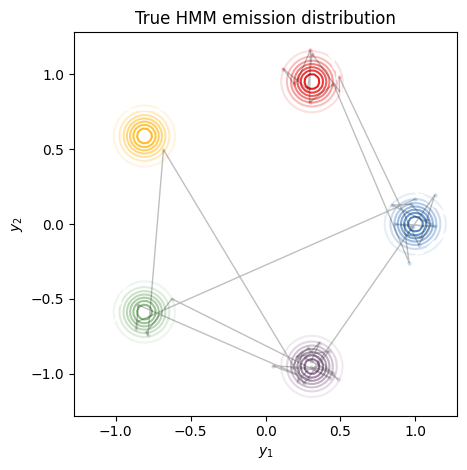

In [5]:
# Plot emissions and true_states in the emissions plane
plot_gaussian_hmm(hmm, true_params, train_emissions[0], train_true_states[0], 
                  title="True HMM emission distribution")

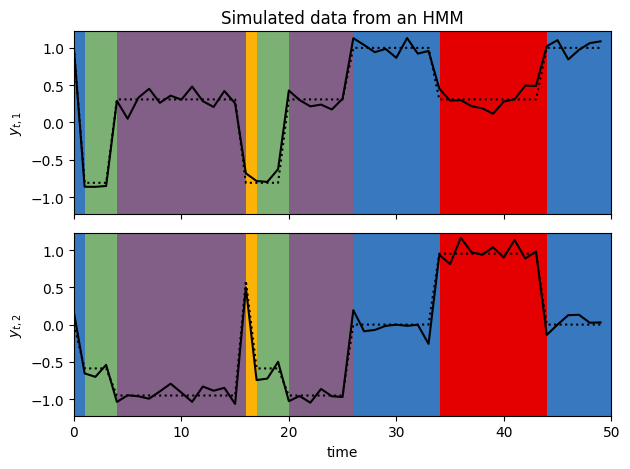

In [6]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_emissions[0], train_true_states[0])

# Test kmeans init

In [7]:
# from dynamax.utils.cluster import kmeans_sklearn, kmeans_jax

# num_states = 3
# key = jr.PRNGKey(90) # set up initial PRNGKey
# #_emission_means, _ = kmeans_sklearn(num_states, train_emissions.reshape(-1, emission_dim), key)
# jax_out_centroids = kmeans_jax(train_emissions.reshape(-1, emission_dim), num_states, key).centroids
# sklearn_out_centroids, _ = kmeans_sklearn(num_states, train_emissions.reshape(-1, emission_dim), key)

# from ott.tools.k_means import k_means as kmeans_ott
# ott_out_centroids = kmeans_ott(train_emissions.reshape(-1, emission_dim), num_states).centroids

## Write a helper function to perform multiple fits with different initialized params

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

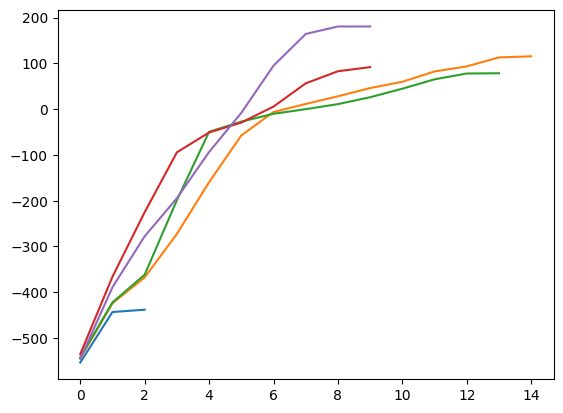

In [8]:
import jax.random as jr
from jax import debug, pmap

model = GaussianHMM(true_num_states, emission_dim)

def initialize_and_fit_hmm(key, emissions):
    params, props = model.initialize(key=key, method="kmeans_ott", emissions=emissions)
    extra_params = {'num_chains': 5}
    fit_params, train_lps = model.fit_em(params, props, emissions, num_iters=25, tolerance=10, **extra_params)
    return fit_params, train_lps

num_fits = 5
key = jr.PRNGKey(90) # set up initial PRNGKey
keys = jr.split(key, num_fits) # JAX array of different PRNG keys

# Use vmap to initialize and fit multiple HMMs simultaneously
fit_params_list, train_lps_list = vmap(initialize_and_fit_hmm, in_axes=(0, None))(keys, train_emissions)

# unpack parameters
(init_probs,), (tmats,), (emi_means, emi_covs,) = fit_params_list

plt.plot(train_lps_list.T)
plt.show()

In [9]:
import jax

@jax.jit
def dynamic_delete(v, i):
  return jnp.where(jnp.arange(len(v) - 2) < i, v[:-2], v[2:])

v = jnp.arange(10)

final_iter = 3
print(dynamic_delete(v, final_iter))

[0 1 2 5 6 7 8 9]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

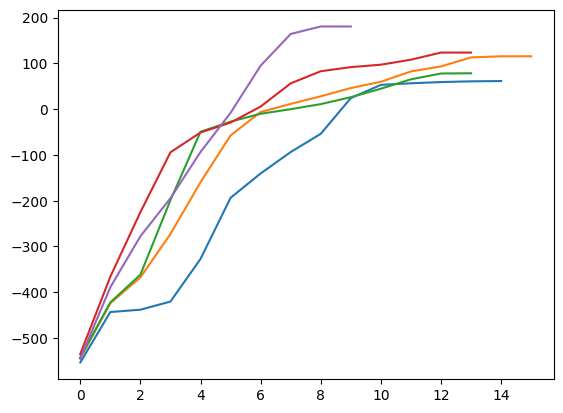

In [9]:
import jax.random as jr
from jax import debug, vmap

model = GaussianHMM(true_num_states, emission_dim)

# Main function to initialize and fit multiple models using parallel execution
def initialize_and_fit_hmm(key, emissions, model_idx):
    params, props = model.initialize(key=key, method="kmeans_ott", emissions=emissions)
    extra_params = {'num_chains': num_fits} #, 'model_idx':model_idx}
    fit_params, train_lps = model.fit_em(params, props, emissions, model_idx=model_idx, num_iters=2000, tolerance=1e-0, **extra_params)
    return fit_params, train_lps

# Set up PRNG keys and emissions data
num_fits = 5
key = jr.PRNGKey(90)  # Set up initial PRNGKey
keys = jr.split(key, num_fits)  # JAX array of different PRNG keys
model_indices = jnp.arange(num_fits)  # Generate model indices
iter

# Use vmap to initialize and fit multiple HMMs simultaneously
fit_params_list, train_lps_list = vmap(initialize_and_fit_hmm, in_axes=(0, None, 0))(keys, train_emissions, model_indices)
train_lps_list = [train_lps_list[i][jnp.logical_not(jnp.isnan(train_lps_list[i]))] for i in range(num_fits)]

# Unpack parameters
(init_probs,), (tmats,), (emi_means, emi_covs,) = fit_params_list

for i in range(num_fits):
    plt.plot(train_lps_list[i])
#plt.plot(train_lps_list.T[1:])
plt.show()

In [1]:
0 % 3

0

In [ ]:
import jax.random as jr
from jax import debug, vmap

model = GaussianHMM(true_num_states, emission_dim)

# Main function to initialize and fit multiple models using parallel execution
def initialize_and_fit_hmm(key, emissions, num_iters, model_idx):
    params, props = model.initialize(key=key, method="kmeans_ott", emissions=emissions)
    extra_params = {'num_chains': num_fits} #, 'model_idx':model_idx}
    fit_params, train_lps = model.fit_em(params, props, emissions, model_idx=model_idx, num_iters=num_iters, tolerance=1e-4, **extra_params)
    return fit_params, train_lps

# Set up PRNG keys and emissions data
num_fits = 5
key = jr.PRNGKey(90)  # Set up initial PRNGKey
keys = jr.split(key, num_fits)  # JAX array of different PRNG keys
model_indices = jnp.arange(num_fits)  # Generate model indices
#num_iters = 50 * jnp.arange(num_fits) + 10
num_iters = jnp.array(50 * jnp.ones(num_fits),dtype=int)

# Use vmap to initialize and fit multiple HMMs simultaneously
fit_params_list, train_lps_list = vmap(initialize_and_fit_hmm, in_axes=(0, None, 0, 0))(keys, train_emissions, num_iters, model_indices)

# Unpack parameters
(init_probs,), (tmats,), (emi_means, emi_covs,) = fit_params_list

plt.plot(train_lps_list.T)
plt.show()

In [ ]:
num_iters = 50 * jnp.arange(10) + 10


In [ ]:

import jax
concrete_val = jax.device_get(traced_obj)


In [ ]:
import jax.random as jr
from jax import debug, vmap

model = GaussianHMM(true_num_states, emission_dim)

def initialize_and_fit_hmm(key, emissions, model_idx):
    debug.print("Fitting model index {model_idx}", model_idx=model_idx)
    params, props = model.initialize(key=key, method="kmeans_ott", emissions=emissions)
    extra_params = {'num_chains': num_fits}  # Pass the total number of chains
    fit_params, train_lps = model.fit_em(params, props, emissions, num_iters=6000, tolerance=1e-4, **extra_params)
    return fit_params, train_lps

num_fits = 5
key = jr.PRNGKey(90) # set up initial PRNGKey
keys = jr.split(key, num_fits) # JAX array of different PRNG keys

# Use vmap to initialize and fit multiple HMMs simultaneously
fit_params_list, train_lps_list = vmap(initialize_and_fit_hmm, in_axes=(0, None, 0))(keys, train_emissions, jnp.arange(num_fits))

# Unpack parameters
(init_probs,), (tmats,), (emi_means, emi_covs,) = fit_params_list

plt.plot(train_lps_list.T)
plt.show()


In [ ]:
jnp.array([False])
print(jnp.array([False])
)

## Write a helper function to perform leave-one-out cross-validation

This function fits the data into _folds_ where each fold consists of all
but one of the training sequences. It fits the model to each fold in 
parallel, and then computes the log likelihood of the held-out sequence for
each fold. The average held-out log likelihood is what we will use for 
determining the number of discrete states.

In [12]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

Now run the cross-validation function on a sequence of models with number of states ranging from 2 to 10.

In [ ]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for i,test_hmm in enumerate(test_hmms):
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(i+30)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

### Plot the individual and average validation log likelihoods as a function of number of states

In [ ]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.title("kmeans_ott")
plt.show()

In [ ]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.title("kmeans_jax")
plt.show()

In [ ]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.title("kmeans_sklearn")
plt.show()

There's no right answer for how to choose the number of states, but reasonable heuristics include:
* picking $K$ that has the highest average validation log prob
* picking $K$ where the average validation log prob stops increasing by a minimum amount
* picking $K$ with a hypothesis test for increasing mean

Here, we'll just choose the number of states with the highest average.

In [ ]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

### Now fit a model to all the training data using the chosen number of states

In [ ]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, emission_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_emissions)
params, lps = test_hmm.fit_em(params, props, train_emissions, num_iters=100)

Plot the log probabilities over the course of training, along with those of the model with the parameters that generated the data.

In [ ]:
# Evaluate the log probability of the training data under the true parameters
true_lp = vmap(partial(hmm.marginal_log_prob, params))(train_emissions).sum()
true_lp += hmm.log_prior(params)

# Plot log probs vs num_iterations
offset = 0
plt.plot(jnp.arange(len(lps)-offset), lps[offset:], label='EM')
plt.axhline(true_lp, color='k', linestyle=':', label="True")
plt.xlabel('num epochs')
plt.ylabel('log prob')
plt.legend()

## Visualize the fitted model

We'll make the same plots as above, but now using the fitted parameters and the chosen number of states.

In [ ]:
most_likely_states = test_hmm.most_likely_states(params, train_emissions[0])
plot_gaussian_hmm(test_hmm, params, train_emissions[0], most_likely_states, 
                  title=f"Fitted Model with {best_num_states} states", alpha=0.25)

In [ ]:
plot_gaussian_hmm_data(test_hmm, params, train_emissions[0], most_likely_states, xlim=(0, 100))

```{important}
Note that the marginal log probability is invariant to relabeling of the states. Compare these plots to the ones at the top from the true model. You'll see that the states have been permuted.
```

## Comparing Gaussian HMMs with different constraints on the covariance

Dynamax implements Gaussian HMMs with different constraints on the covariance matrices:
* [`DiagonalGaussianHMM`](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.DiagonalGaussianHMM) assumes the covariance matrices are diagonal (i.e. $\Sigma_k = \mathrm{diag}([\sigma_{k,1}^2, \ldots, \sigma_{k,D}^2])$)
* [`SphericalGaussianHMM`](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.SphericalGaussianHMM) assumes the covariance matrices are "spherical" (i.e. $\Sigma_k = \sigma_k^2 I$)
* [`SharedCovarianceGaussianHMM`](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.SharedCovarianceGaussianHMM) assumes the covariance matrices are the same for all states (i.e. $\Sigma_k = \Sigma$)

In this last section, we will compare these models based on the marginal probability they assign to the test data.

```{warning}
Usually, you would use cross-validation to choose the number of discrete states for each type of model, and then evaluate them on test data. For simplicity, we will assume that we know the true number of states.
```

In [ ]:
def fit_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    params, lps = model.fit_em(params, props, train_emissions, num_iters=num_iters, verbose=False)
    test_lp = vmap(partial(model.marginal_log_prob, params))(test_emissions).sum()
    return test_lp

models = [
    GaussianHMM(true_num_states, emission_dim, transition_matrix_stickiness=10.),
    DiagonalGaussianHMM(true_num_states, emission_dim, transition_matrix_stickiness=10.),
    SphericalGaussianHMM(true_num_states, emission_dim, transition_matrix_stickiness=10.),
    SharedCovarianceGaussianHMM(true_num_states, emission_dim, transition_matrix_stickiness=10.),
]

# Fit the models and collect the test log probabilities
key = jr.PRNGKey(0)
test_lps = [fit_model(model, key) for model in models]
# Compare to the log probability under the true model
true_test_lp = vmap(partial(hmm.marginal_log_prob, true_params))(test_emissions).sum()

print("Marginal log probabilities of test data:")
for model, test_lp in zip(models, test_lps):
    print(f"{model.__class__.__name__: >30}: {test_lp: .1f}")
print(f"{'True Model': >30}: {true_test_lp: .1f}")

Here, the `DiagonalGaussianHMM` has the highest test log likelihood, and it's almost as high as the log probability under the true parameters. The standard `GaussianHMM`, which allows for arbitrary covariance matrices is underperforming on test data, likely because it overfits the training data with its extra flexibility. 

Here, the true parameters were in fact spherical and shared across all states, so it's perhaps a bit surprising that the more general diagonal covariance model wins out on test data. Keep in mind, however, that there is some amount of randomness in both the sampled data and the initialization of these models, so the particular ordering might change from one random seed to the next. In actual applications, you should compute means and standard errors by running these analyses with multiple random seeds. 

## Conclusion

Dynamax provides a family of Gaussian HMMs for multivariate continuous emissions. This notebook showed how to use cross-validation to choose the number of discrete states, and how to compare model families (e.g. `GaussianHMM` vs `DiagonalGaussianHMM`) on test data. 

Now that you have seen HMMs with categorical and Gaussian emissions, you can pattern-match to use the other HMMs. See the [documentation](https://probml.github.io/dynamax/api.html#high-level-models) for a complete list.

The next notebook highlights one more generalization of the standard HMM to _autoregressive_ emissions, where the emissions depend on preceding emissions as well as the current discrete state.